<a href="https://colab.research.google.com/github/nate-walter/Diabetic-Retinopathy-Neural-Network/blob/main/Kappa_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this Notebook, AdamW was used (after much trouble) as the compiler

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# !unzip /content/gdrive/MyDrive/IDRid_train_floder/fianl_IDRiD_train_images.zip > /dev/null
# !unzip /content/gdrive/MyDrive/test_IDRiD_test/test_image2s.zip > /dev/null
# !unzip /content/gdrive/MyDrive/aptos-folder/train_aptos.zip > /dev/null
# !unzip /content/gdrive/MyDrive/resized-folder/train_resized.zip > /dev/null
# !unzip /content/gdrive/MyDrive/combined_folder/train_combined.zip > /dev/null

In [ ]:
# !pip install tensorflow-addons > /dev/null
# !pip install keras_tuner > /dev/null
# !pip install tensorflow > /dev/null

# Cleaning and  EDA


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns

import tensorflow as tf
import keras                                               
from keras.models import Model, save_model
from keras.models import Sequential
#**Import from keras_preprocessing not from keras.preprocessing**
from keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import regularizers, optimizers, applications
from tensorflow.keras.optimizers import RMSprop, Adam 
from tensorflow.keras import layers
import tensorflow_addons as tsa
from tensorflow_addons.optimizers import AdamW 


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

## Aptos 2019 Dataset

In [ ]:
aptos = pd.read_csv('/content/gdrive/MyDrive/aptos_2019_train.csv')
#aptos_test = pd.read_csv('Aptos2019-Blindness-Detection-Kaggle/test.csv')

aptos.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
aptos.diagnosis.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

### Having a look at examples of Diabetic Retinopathy (DR) and no Diabetic Retinopathy

In [ ]:
train_images = "train_combined/"

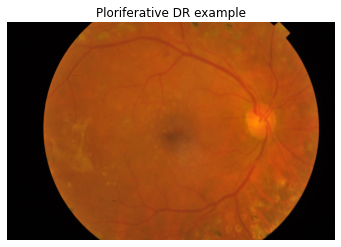

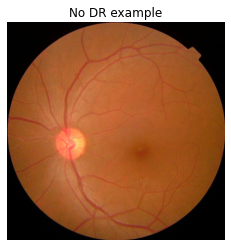

In [ ]:
img = load_img(train_images +  aptos['id_code'].iloc[1] +".png")
plt.imshow(img)
plt.title('Ploriferative DR example')
plt.axis("off")
plt.show()
img = load_img(train_images +  aptos['id_code'].iloc[3] +".png")
plt.imshow(img)
plt.title('No DR example')
plt.axis("off")
plt.show()

### We'll have to add .png to the end of all those values in the id_label column if we're going to be able to connect them with the image files, and we'll also have to turn the diagnosis labels from into to str

In [ ]:
aptos.id_code = aptos.id_code.apply(lambda x : "{}{}".format(x, ".png"))

aptos.diagnosis = aptos.diagnosis.astype(str)

type(aptos.diagnosis.iloc[0])

str

## Grabbing half the 0 labels as a step toward achieving class balance in the dataset

In [ ]:
df_odd = aptos[aptos['diagnosis'] == '0']
df_odd.head()

,id_code,diagnosis
3,002c21358ce6.png,0
4,005b95c28852.png,0
6,0097f532ac9f.png,0
10,00cc2b75cddd.png,0
12,00f6c1be5a33.png,0


### Locating only odd rows with label 0

In [ ]:
df_odd = df_odd.loc[df_odd.index % 2 == 1, :]
print(len(df_odd))

890


We have to drop all of the original rows containing label 0. Don't worry we'll replace them with half the original amount

In [ ]:
aptos = aptos[aptos['diagnosis'] != '0']
print(aptos['diagnosis'].value_counts())

2    999
1    370
4    295
3    193
Name: diagnosis, dtype: int64


Here, see I told you we'd put half of them back in 

In [ ]:
aptos = pd.concat([aptos, df_odd], ignore_index=True)
aptos['diagnosis'].value_counts()

2    999
0    890
1    370
4    295
3    193
Name: diagnosis, dtype: int64

## IDRiD Train DataSet

In [ ]:
idrid = pd.read_csv('/content/gdrive/MyDrive/IDRiD_train_labels.csv')

idrid.head()

,Image name,Retinopathy grade,Risk of macular edema,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,IDRiD_001,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IDRiD_002,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IDRiD_003,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IDRiD_004,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IDRiD_005,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Renaming our two columns of interest

In [ ]:
idrid = idrid.rename(columns={"Image name": "id_code", "Retinopathy grade": "diagnosis"})

idrid.head()

,id_code,diagnosis,Risk of macular edema,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,IDRiD_001,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IDRiD_002,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IDRiD_003,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IDRiD_004,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IDRiD_005,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Adding .png to the Image names 

In [ ]:
idrid['id_code'] = idrid['id_code'].apply(lambda x : "{}{}".format(x, ".png"))
idrid.head()

,id_code,diagnosis,Risk of macular edema,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,IDRiD_001.png,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IDRiD_002.png,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IDRiD_003.png,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IDRiD_004.png,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IDRiD_005.png,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Converting the Retinopathy diagnosis to str

In [ ]:
idrid['diagnosis'] = idrid['diagnosis'].astype(str)

### We're not interested in anything but the image id number (Image name) and Retinopathy grade columns. So let's drop all other columns

In [ ]:
idrid = idrid[['id_code', 'diagnosis']]

idrid.head()

,id_code,diagnosis
0,IDRiD_001.png,3
1,IDRiD_002.png,3
2,IDRiD_003.png,2
3,IDRiD_004.png,3
4,IDRiD_005.png,4


That looks like our aptos df from above. That's good. Now let's see how many of each label we're working with

In [ ]:
idrid.diagnosis.value_counts()

2    136
0    134
3     74
4     49
1     20
Name: diagnosis, dtype: int64

### All 0 labels

In [ ]:
idrid.loc[idrid['diagnosis']== '0']

idrid.head()

,id_code,diagnosis
0,IDRiD_001.png,3
1,IDRiD_002.png,3
2,IDRiD_003.png,2
3,IDRiD_004.png,3
4,IDRiD_005.png,4


Quick look at aptos df too

In [ ]:
aptos.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,0083ee8054ee.png,4
4,00a8624548a9.png,2


### There. Now we can concatenate the two DataFrames and make one dataframe

In [ ]:
df = pd.concat([aptos, idrid], ignore_index = True)

df.tail(10)
# looks like the idrid dataframe is at the bottom like we wanted

,id_code,diagnosis
3150,IDRiD_404.png,2
3151,IDRiD_405.png,2
3152,IDRiD_406.png,0
3153,IDRiD_407.png,2
3154,IDRiD_408.png,1
3155,IDRiD_409.png,2
3156,IDRiD_410.png,2
3157,IDRiD_411.png,2
3158,IDRiD_412.png,2
3159,IDRiD_413.png,2


In [ ]:
# let's check that aptos is at the top
df.head(10)
# it is

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,0083ee8054ee.png,4
4,00a8624548a9.png,2
5,00b74780d31d.png,2
6,00cb6555d108.png,1
7,00e4ddff966a.png,2
8,0104b032c141.png,3
9,0124dffecf29.png,1


How's the balance between classes looking

In [ ]:
df['diagnosis'].value_counts()

2    1135
0    1024
1     390
4     344
3     267
Name: diagnosis, dtype: int64

Not great, but be patient, I've already gone ahead and done some work (hint: they even out)

# Bring in the Bohemoth 2015 Aptos Training Set

In [ ]:
aptos15 = pd.read_csv('/content/gdrive/MyDrive/aptos-2015-training.csv')
aptos15.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [ ]:
len(aptos15)

35126

### Let's rename the columns, for soliderity's sake

In [ ]:
aptos15.rename(columns={"image": "id_code", "level": "diagnosis"}, inplace=True)

### adding jpg to the end of aptos15 id_code records and converting diagnosis column to str

In [ ]:
aptos15.id_code = aptos15.id_code.apply(lambda x : "{}{}".format(x, ".jpg"))

aptos15.diagnosis = aptos15.diagnosis.astype(str)

In [ ]:
aptos15.head()

,id_code,diagnosis
0,10_left.jpg,0
1,10_right.jpg,0
2,13_left.jpg,0
3,13_right.jpg,0
4,15_left.jpg,1


In [ ]:
aptos15['diagnosis'].value_counts()

0    25810
2     5292
1     2443
3      873
4      708
Name: diagnosis, dtype: int64

### We're going to drop the 0 labels all together for now 

In [ ]:
aptos15 = aptos15[aptos15['diagnosis'] !='0']

aptos15

,id_code,diagnosis
4,15_left.jpg,1
5,15_right.jpg,2
6,16_left.jpg,4
7,16_right.jpg,4
9,17_right.jpg,1
...,...,...
35098,44323_left.jpg,1
35099,44323_right.jpg,1
35105,44328_right.jpg,1
35112,44337_left.jpg,1


## Let's Get Just Half the Rows for Diagnosis 1

In [ ]:
df_even = aptos15[aptos15['diagnosis'] == '1']
df_even

df_even = df_even.loc[df_even.index % 2 == 0, :]
len(df_even)

1212

### We'll use df_even a little bit down the road

In [ ]:
aptos15['diagnosis'].value_counts()

2    5292
1    2443
3     873
4     708
Name: diagnosis, dtype: int64

### Getting rid of all the diagnosis 1 rows in aptos 15 now that we have the amount in df_even that we need

In [ ]:
aptos15 = aptos15[aptos15['diagnosis'] != '1']

In [ ]:
aptos15['diagnosis'].value_counts()

2    5292
3     873
4     708
Name: diagnosis, dtype: int64

In [ ]:
aptos15 = aptos15[aptos15['diagnosis'].isin(['3','4'])]
aptos15['diagnosis'].value_counts()

3    873
4    708
Name: diagnosis, dtype: int64

In [ ]:
aptos15['diagnosis'].unique()

array(['4', '3'], dtype=object)

# We're bringing in the test data from IDRiD because...more

In [ ]:
test_idrid = pd.read_csv('/content/gdrive/MyDrive/IDRiD_test_labels.csv')
test_idrid = test_idrid.drop(test_idrid.columns[[2]], axis=1) # Drop Macular Adema column
test_idrid.head()

,Image name,Retinopathy grade
0,IDRiD_001,4
1,IDRiD_002,4
2,IDRiD_003,4
3,IDRiD_004,4
4,IDRiD_005,4


In [ ]:
# frist change the names of columns to match other dataframes
# then add .png to image name column and turning Retinopathy grade values to str

test_idrid.rename(columns={"Image name": "id_code", "Retinopathy grade": "diagnosis"}, inplace=True)

test_idrid['id_code'] = test_idrid['id_code'].apply(lambda x : "{}{}".format("test_" + x, ".png"))

test_idrid['diagnosis'] =  test_idrid['diagnosis'].astype(str)

test_idrid.head()

,id_code,diagnosis
0,test_IDRiD_001.png,4
1,test_IDRiD_002.png,4
2,test_IDRiD_003.png,4
3,test_IDRiD_004.png,4
4,test_IDRiD_005.png,4


In [ ]:
test_idrid['diagnosis'].value_counts()

0    34
2    32
3    19
4    13
1     5
Name: diagnosis, dtype: int64

drop all but values 3, 4 and 0

In [ ]:
test_idrid = test_idrid[test_idrid['diagnosis'].isin(['0','3','4'])]
test_idrid.head()

,id_code,diagnosis
0,test_IDRiD_001.png,4
1,test_IDRiD_002.png,4
2,test_IDRiD_003.png,4
3,test_IDRiD_004.png,4
4,test_IDRiD_005.png,4


In [ ]:
test_idrid['diagnosis'].unique()

array(['4', '3', '0'], dtype=object)

### combing test_idrid and df

In [ ]:
df = pd.concat([df, test_idrid], ignore_index=True)

df.tail()

,id_code,diagnosis
3221,test_IDRiD_096.png,0
3222,test_IDRiD_097.png,0
3223,test_IDRiD_098.png,0
3224,test_IDRiD_099.png,0
3225,test_IDRiD_103.png,0


In [ ]:
df = pd.concat([df, test_idrid], ignore_index=True)

df.tail()

,id_code,diagnosis
3287,test_IDRiD_096.png,0
3288,test_IDRiD_097.png,0
3289,test_IDRiD_098.png,0
3290,test_IDRiD_099.png,0
3291,test_IDRiD_103.png,0


In [ ]:
df['diagnosis'].value_counts()

2    1135
0    1092
1     390
4     370
3     305
Name: diagnosis, dtype: int64

dropping all the l labels fromt the datarame

In [ ]:
df = df[df['diagnosis'] != '1']

### Enter our df_even from above. Let's combine it with df

In [ ]:
df = pd.concat([df, df_even], ignore_index=True)

df['diagnosis'].value_counts()

1    1212
2    1135
0    1092
4     370
3     305
Name: diagnosis, dtype: int64

### Now combine aptos 15

In [ ]:
df = pd.concat([df, aptos15], ignore_index=True )

### Hey look at that, all our labels seem to be around the same amount. All that work payed off

In [ ]:
df['diagnosis'].value_counts()

1    1212
3    1178
2    1135
0    1092
4    1078
Name: diagnosis, dtype: int64

### Percentage-wise?

In [ ]:
df['diagnosis'].value_counts(normalize=True)

1    0.212818
3    0.206848
2    0.199298
0    0.191747
4    0.189289
Name: diagnosis, dtype: float64

Looks good to me, they're all around 20%


In [ ]:
counts = df['diagnosis'].value_counts(normalize=True)

### A look at the Labels distribution

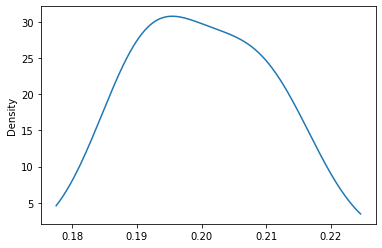

In [ ]:
counts.plot.kde();

### That looks like a bell to me. Let's see the labels in bar-form

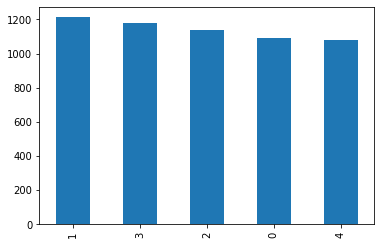

In [ ]:
df['diagnosis'].value_counts().plot(kind='bar');

## Much better
the dataset looks fairly balanced, ready to run through a model I'd say

## How many images are we working with? 

In [ ]:
print(len(df))
print("Cool We've got more than 5,000 retinas to work with!")

5695
Cool We've got more than 5,000 retinas to work with!


# First, Let's break off some dedicated rows and set them aside to test on

In [ ]:
train=df.sample(frac=0.8,random_state=42) #random state is a seed value
test=df.drop(train.index)

# First Thing's First

## –The Baseline Model–

In [ ]:
from sklearn.dummy import DummyClassifier

X = df['id_code']
y = df['diagnosis']

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(X)

dummy_clf.score(X, y)


0.2128182616330114

This totally lines up with the idea of a model picking the most frequent class, since pretty much all our labels made up 20% of the data, after cleaning. It's not surprising that we have about 20% accuracy from our baseline.  

## I have a feeling we can do better than that

# Using flow_from_dataframe( ) to create train, test, validate data

In [ ]:
#Train flow_from_dataframe
datagen=ImageDataGenerator(rescale=1./255.,
                           brightness_range=(0.95, 0.99), 
                           shear_range=0.05,
                           zoom_range=0.05,
                           height_shift_range=0.05,
                           width_shift_range=0.05,
                           validation_split=0.20, 
                           horizontal_flip=True, 
                           rotation_range=20)


# # Validate flow_from_dataframe
valgen = ImageDataGenerator(rescale=1./255., validation_split=0.20) 


# Train flow_from_datafram
train_generator=datagen.flow_from_dataframe(
dataframe=train, 
directory="/content/train_combined/",  
x_col="id_code",
y_col="diagnosis",
subset="training",
batch_size=16,  #next time after Iota try batch 32**********
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(512,512)) 

# Validation flow_from_dataframe
valid_generator=valgen.flow_from_dataframe(
dataframe=train,
directory="/content/train_combined/",
x_col="id_code",
y_col="diagnosis",
subset="validation",
batch_size=16, 
seed=42,
shuffle=True, 
class_mode="categorical",
target_size=(512,512))

# Test flow_from_dataframe
test_datagen=ImageDataGenerator(rescale=1./255.)


test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="/content/train_combined/",
x_col="id_code",
y_col="diagnosis",
batch_size=1, 
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(512,512)) # not sure if we change test sizes????

Found 3313 validated image filenames belonging to 5 classes.
Found 828 validated image filenames belonging to 5 classes.
Found 1029 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 415 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 415 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 110 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# Kappa Model

## Now Let's use ResNet50_V2 but replace the last layer with our own

In [ ]:
from keras.applications.resnet_v2 import ResNet50V2
base_model_kappa = ResNet50V2(include_top=False, weights='imagenet', input_shape=(512,512,3))

x = base_model_kappa.output

x = GlobalAveragePooling2D()(x)
x = Dense(512, activation= 'relu')(x) 
x = Dropout(.2)(x)


predictions = Dense(5, activation= 'softmax')(x)
resnet_model_kappa = Model(inputs=base_model_kappa.input,  outputs=predictions)

for layer in base_model_kappa.layers:
  layer.trainable = False

# Must compile the Kappa model with our ***Brand New AdamW!***

In [ ]:
# thanks to hugoych on https://github.com/tensorflow/addons/issues/844

lr_schedule = tf.optimizers.schedules.ExponentialDecay(1e-4, 100, 0.9)
wd_schedule = tf.optimizers.schedules.ExponentialDecay(5e-5, 100, 0.9)
opt = AdamW(learning_rate=lr_schedule, weight_decay=lambda : None)
opt.weight_decay = lambda : wd_schedule(opt.iterations)
resnet_model_kappa.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resnet_model_kappa.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 258, 258, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# class DecayHistory(tf.keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.lr = []
#         self.wd = []
#     def on_batch_end(self, batch, logs={}):
#         self.lr.append(self.model.optimizer.lr(self.model.optimizer.iterations))
#         self.wd.append(self.model.optimizer.weight_decay)

## Fit *Kappa Model*

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
207/207 [==============================] - 433s 2s/step - loss: 1.0997 - accuracy: 0.5766 - val_loss: 0.9182 - val_accuracy: 0.6336
Epoch 2/100
207/207 [==============================] - 427s 2s/step - loss: 0.8596 - accuracy: 0.6779 - val_loss: 0.8070 - val_accuracy: 0.6838
Epoch 3/100
207/207 [==============================] - 427s 2s/step - loss: 0.7846 - accuracy: 0.7006 - val_loss: 0.7613 - val_accuracy: 0.7181
Epoch 4/100
207/207 [==============================] - 428s 2s/step - loss: 0.7345 - accuracy: 0.7185 - val_loss: 0.7296 - val_accuracy: 0.7255
Epoch 5/100
207/207 [==============================] - 427s 2s/step - loss: 0.7119 - accuracy: 0.7316 - val_loss: 0.7196 - val_accuracy: 0.7279
Epoch 6/100
207/207 [==============================] - 426s 2s/step - loss: 0.6972 - accuracy: 0.7349 - val_loss: 0.7241 - val_accuracy: 0.7206
Epoch 7/100
207/207 [==============================] - 426s 2s/step - loss: 0.6742 - accuracy: 0.7470 - val_loss: 0.6839 - val_accuracy:

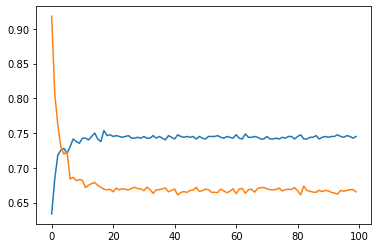

In [ ]:
 epochs = 100


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history = resnet_model_kappa.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs
)



                    

#plot metrics
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.show()
plt.show()

## Let's See how the Kappa-Model performs on the roughly 800 retinal images in our test data that it's never seen before!

In [ ]:
test_loss, test_acc = resnet_model_kappa.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

1029/1029 - 64s - loss: 0.7139 - accuracy: 0.7230

Test accuracy: 0.7230320572853088


## And Here's Kappa-Model's Confusion Matrix

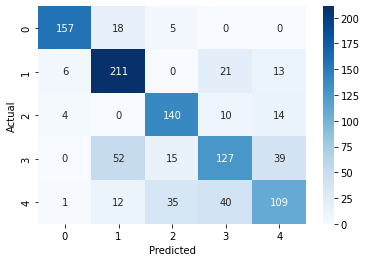

test accuracy : 72.30320699708454


In [ ]:
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(resnet_model_kappa.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]


out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

# thanks to https://github.com/jakkcoder/ResNet50/blob/master/ResNet50.ipynb for the confusion matrix code

# The Saved ***Kappa-Model***

In [ ]:
filepath = './saved_kappa_model.h5'
save_model(resnet_model_kappa, filepath, save_format='h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


TypeError: ignored